In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import roc_auc_score, f1_score, matthews_corrcoef, balanced_accuracy_score
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

from my_util import *
from lime.lime.lime_tabular import LimeTabularExplainer


import sys, os,  pickle, time

sys.path.append(os.path.abspath('../pyexplainer'))
from pyexplainer_pyexplainer import *

# from datetime import datetime

from IPython.display import display

In [13]:
data_path = './dataset/'
result_dir = './eval_result/'
dump_dataframe_dir = './dump_df/'
pyExp_dir = './pyExplainer_obj/'
other_object_dir = './other_object/'
proj_name = 'qt' # ['openstack','qt']



if not os.path.exists(result_dir):
    os.makedirs(result_dir)
    
if not os.path.exists(dump_dataframe_dir):
    os.makedirs(dump_dataframe_dir)
    
if not os.path.exists(pyExp_dir):
    os.makedirs(pyExp_dir)
    
if not os.path.exists(other_object_dir):
    os.makedirs(other_object_dir)

## Prepare data

In [25]:
x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')

In [15]:
# display(x_train)

In [16]:
# # print(y_train)
# for col in x_test.columns:
#     print(col,len(x_test[col].unique()))

col = list(x_test.columns)
# print(col)
# print(col.index('self'))

## Train global model

In [6]:
smt = SMOTE(k_neighbors=5, random_state=42, n_jobs=24)
# enn = EditedNearestNeighbours(n_neighbors=5, n_jobs=24)
# smt_tmk = SMOTETomek(smote = smt, random_state=0)
# smt_enn = SMOTEENN(smote=smt, enn=enn, random_state=0)

new_x_train, new_y_train = smt.fit_resample(x_train, y_train)

def train_global_model(x_train,y_train):
    global_model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=24)
    global_model.fit(x_train, y_train)

    pickle.dump(global_model, open(proj_name+'_global_model.pkl','wb'))
    print('train global model finished')
    
train_black_box = True

if train_black_box:
    train_global_model(new_x_train, new_y_train)

train global model finished


## Obtain correctly predicted defective commits

In [17]:
global_model = pickle.load(open(proj_name+'_global_model.pkl','rb'))
# x_test, y_test = prepare_data(proj_name, mode = 'test')

pred = global_model.predict(x_test)
defective_prob = global_model.predict_proba(x_test)[:,1]

prediction_df = x_test.copy()
prediction_df['pred'] = pred
prediction_df['defective_prob'] = defective_prob
prediction_df['defect'] = y_test

print('AUC is',roc_auc_score(y_test, defective_prob))
correctly_predict_df = prediction_df[(prediction_df['pred']==1) & (prediction_df['defect']==1)]

AUC is 0.7350656132213174


In [18]:
print(len(correctly_predict_df))
prediction_df.to_csv(dump_dataframe_dir+proj_name+'_prediction_result.csv')
correctly_predict_df.to_csv(dump_dataframe_dir+proj_name+'_correctly_predict_as_defective.csv')


79


## Check overfitting and underfitting of global model

In [72]:
proj_name = 'qt'
global_model = pickle.load(open(proj_name+'_global_model.pkl','rb'))
x_train, x_test, y_train, y_test = prepare_data(proj_name, mode = 'all')
train_pred = global_model.predict(x_train)
train_prob = global_model.predict_proba(x_train)[:,1]
test_pred = global_model.predict(x_test)
test_prob = global_model.predict_proba(x_test)[:,1]

In [73]:
print('AUC score')
print(roc_auc_score(y_train, train_prob), roc_auc_score(y_test, test_prob))
print('F1 score')
print(f1_score(y_train, train_pred), f1_score(y_test, test_pred))
print('MCC score')
print(matthews_corrcoef(y_train, train_pred), matthews_corrcoef(y_test, test_pred))
print('Balance Accuracy')
print(balanced_accuracy_score(y_train, train_pred), balanced_accuracy_score(y_test, test_pred))

AUC score
1.0 0.7350656132213174
F1 score
1.0 0.20954907161803715
MCC score
1.0 0.18150193170830922
Balance Accuracy
1.0 0.5702284182484685


{'whiskers': [<matplotlib.lines.Line2D at 0x7f194be8c490>,
 'caps': [<matplotlib.lines.Line2D at 0x7f194be8cfd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1949d5b910>],
 'medians': [<matplotlib.lines.Line2D at 0x7f194be8c310>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f1950a4e4f0>],
 'means': []}

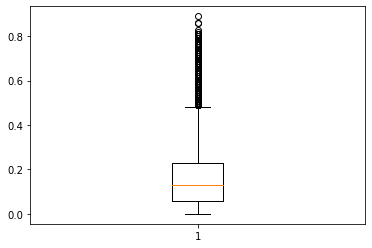

In [74]:
plt.boxplot([test_prob])
# print(np.sum(y_test==test_pred))
# print(np.sum(np.array(list(y_test))==np.array(test_pred)))
# print(y_test)

# df = pd.DataFrame()
# df['pred'] = test_pred
# df['label'] = list(y_test)
# print(df[(df['pred']==True) & (df['label']==True)])
# print(np.sum(y_test))

## Training local model

Note: this step includes instance generation

In [19]:
print(correctly_predict_df.columns[:-3])

Index(['la', 'ld', 'nd', 'ns', 'ent', 'nrev', 'rtime', 'hcmt', 'self', 'ndev',
       'age', 'app', 'asexp', 'rsexp', 'asawr', 'rsawr'],
      dtype='object')


In [20]:
global_model = pickle.load(open(proj_name+'_global_model.pkl','rb'))

load_prediction_from_file = True
class_label = ['clean', 'defect']

if load_prediction_from_file:
    correctly_predict_df = pd.read_csv(dump_dataframe_dir+proj_name+'_correctly_predict_as_defective.csv')
    correctly_predict_df = correctly_predict_df.set_index('commit_id')
    
dep = 'defect'
indep = correctly_predict_df.columns[:-3] # exclude the last 3 columns

# print(correctly_predict_df.columns)
# print(len(correctly_predict_df.columns))
# print(indep)
# display(correctly_predict_df)

In [21]:
# for our apporach
pyExp = PyExplainer(x_train, y_train, indep, dep, global_model, class_label)

# for baseline
# note: 6 is index of 'self' feature
lime_explainer = LimeTabularExplainer(x_train.values, categorical_features=[6],
                                      feature_names=indep, class_names=class_label, 
                                      discretizer = 'decile', random_state=0)

In [22]:
feature_df = correctly_predict_df.loc[:, indep]
test_label = correctly_predict_df.loc[:, dep]
problem_index = [] # store index that cannot build pyExplainer

In [23]:
'''
    search function: lime or crossoverinterpolation
'''
def create_pyExplainer_obj(search_function, feature_df, test_label, explainer='rulefit'):
    
    if search_function.lower() not in ['lime','CrossoverInterpolation']:
        print('the search function must be "lime" or "CrossoverInterpolation"')
        return
    
    problem_index = []
    time_spent = []
    
    for i in range(0,len(feature_df)):
        X_explain = feature_df.iloc[[i]]
        y_explain = test_label.iloc[[i]]

        row_index = str(X_explain.index[0])

        start = time.time()
        try:
            if search_function=='CrossoverInterpolation':
                # the returned object is dictionary
                pyExp_obj = pyExp.explain(X_explain,
                                           y_explain,
                                           search_function = search_function, 
                                           top_k = 15,
                                           max_rules=2000, 
                                           max_iter = None, 
                                           cv=5,
                                           debug = False)
    #             synt_pred = pyExp_obj['synthetic_predictions']
                pyExp_obj['commit_id'] = row_index
        
                # because I don't want to change key name in another evaluation file
                pyExp_obj['local_model'] = pyExp_obj['local_rulefit_model']
                del pyExp_obj['local_rulefit_model']
    #             print('{}: found {} defect from total {}'.format(row_index, str(np.sum(synt_pred)), 
    #                                                          str(len(synt_pred))))
                pickle.dump(pyExp_obj, open(pyExp_dir+proj_name+'_'+explainer+'_'+search_function.lower()+'_'+row_index+'_2000_instances.pkl','wb'))
        
            else:
                X_explain = feature_df.iloc[i] # to prevent error in LIME
                exp, synt_inst, synt_inst_for_local_model, selected_feature_indices, local_model = lime_explainer.explain_instance(X_explain, 
                                                                                                                                   global_model.predict_proba, 
                                                                                                                                   num_samples=2000,)

                lime_obj = {}
                lime_obj['rule'] = exp
                lime_obj['synthetic_instance_for_global_model'] = synt_inst
                lime_obj['synthetic_instance_for_lobal_model'] = synt_inst_for_local_model
                lime_obj['local_model'] = local_model
                lime_obj['selected_feature_indeces'] = selected_feature_indices
                lime_obj['commit_id'] = row_index
                pickle.dump(lime_obj, open(pyExp_dir+proj_name+'_lime_'+row_index+'_2000_instances.pkl','wb'))
                
            print('finished',row_index)
#             print(row_index)
#             print('just one rulefit is enough')
#             break
            
        except Exception as e:
            problem_index.append(row_index)
            print('-'*100)
            print(e)
#             print('found total {} problematic commit'.format(str(len(problem_index))))
            print('-'*100)
            
#         break

        end = time.time()

        time_spent.append(str(end-start))
#     print(row_index)
#     break
    
    print('from total {} commits, there are {} problematic commits'.format(len(feature_df),len(problem_index)))
    return time_spent, problem_index

In [24]:
time_spent_rand, problem_index_rand = create_pyExplainer_obj('lime', feature_df, test_label)
pickle.dump(time_spent_rand, open(other_object_dir+proj_name+'_train_time_lime_randompertubation.pkl','wb'))
pickle.dump(problem_index_rand, open(other_object_dir+proj_name+'_problem_index_lime_randompertubation.pkl','wb'))

# time_spent_rand, problem_index_rand = create_pyExplainer_obj('lime', feature_df, test_label,'rulefit')
# pickle.dump(time_spent_rand, open(other_object_dir+proj_name+'_train_time_lime.pkl','wb'))
# pickle.dump(problem_index_rand, open(other_object_dir+proj_name+'_problem_index_lime.pkl','wb'))

--------------------------------------------------------------------------------
finished f5dbc876378ae58a7bdfe1e9664fc81caca18dfb
--------------------------------------------------------------------------------
finished 602bd9873786ccadcb67da3036329f3122555cf8
--------------------------------------------------------------------------------
finished 9d75626b1073113d77988bcb52e99215d5af4787
--------------------------------------------------------------------------------
finished 3168c94577cc604fd033ce4e741da5c411f74666
--------------------------------------------------------------------------------
finished 23bdca417bde716c79168ab372083fd885607123
--------------------------------------------------------------------------------
finished 438211ec627073817fcaf6d3a07b76f2aa5d90e0
--------------------------------------------------------------------------------
finished d8090022f66cc6cff6af5ed2ae702212fd172ff7
--------------------------------------------------------------------------------
fi

--------------------------------------------------------------------------------
finished 72420889aa54342da4472683e67e2c70b76a170f
--------------------------------------------------------------------------------
finished 9424383e6d0ea1dd02dcf1070259e21550da692a
--------------------------------------------------------------------------------
finished 6953f3a501dfee5064a12558a2e2515b69b35189
--------------------------------------------------------------------------------
finished d437457becef4409682caee15e1050889a977f91
--------------------------------------------------------------------------------
finished e4588b70dde3fe5ba8f77a0b749ec1b071346767
--------------------------------------------------------------------------------
finished a2e92f6dee12320a58a4bcc95c14649b27804427
--------------------------------------------------------------------------------
finished ccb088a6beaff01419ec9325dbd19040f279b6ea
--------------------------------------------------------------------------------
fi

In [ ]:
# time_spent_ci, problem_index_ci = create_pyExplainer_obj('crossoverinterpolation', feature_df, test_label)
# pickle.dump(time_spent_ci, open(other_object_dir+proj_name+'_train_time_LRR_crossoverinterpolation.pkl','wb'))
# pickle.dump(problem_index_ci, open(other_object_dir+proj_name+'_problem_index_LRR_crossoverinterpolation.pkl','wb'))

time_spent_ci, problem_index_ci = create_pyExplainer_obj('CrossoverInterpolation', feature_df, test_label,'rulefit')
pickle.dump(time_spent_ci, open(other_object_dir+proj_name+'_train_time_rulefit_crossoverinterpolation.pkl','wb'))
pickle.dump(problem_index_ci, open(other_object_dir+proj_name+'_problem_index_rulefit_crossoverinterpolation.pkl','wb'))

finished 1e6973aee7137653c62dcef970b1e2527b50517d
finished 5d0ccceb20780fdd3adf519d3f8e6b80b1844407
finished de31210c05f464c4a79255de68b1a515d9b84ed3
finished 957533f685caf9ffc0d9cad569598455d59ade34
finished 96677735f6d8f1f5b6380127956921f719aab799
finished 10593c2eaf4eff4edb13b70f023acbbf743f129f
finished 8db51da1e25f1c148fbe8d8f27d144a39d1850f3
finished ba4ed39616c3c6fabf24ca390c7037877c672fba
finished 2c62e344e26ccba08d5c613a7c4a40a0f076901e
finished 207a7825fbcc69c4c3d4bfefd8e9c33978162ed9
finished 03a41f863b160384593ef8df130f369a0c22d393
finished f0ce71c23c786baf7c828d1fd147d70342593a10
finished b199471154cb4be2d7d9c89939bb31e90f3adff4
finished 608c67439c8fcfa1a2fddd1087ca1fe998a8f9fd
finished 1e90eb66ae999201a0b3d2e7409734c3e2f452d7
finished e8440d1ee8da2cbf4304bbbc0bf43ce78d7a6d1f
finished a9230a38977d6acb804ee8bb6f58c19957dce013
finished e3e4f4d9277c22654ce0dd9a1a0f44a67661e695
finished b6133c35dd587f6b01e8ec12757347b2767713a6
finished 262bdf68b45058fedffda614336d7e75a5b36d4a


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


finished 3fd1beb85c0888251781fe56b067b08c4957b94b
finished 486e10d3740301b417e2a972ec7c797f562e75be
finished 2f49ed4b5dbb5c954fc7a9b42ee7b170c38c775c
finished 65aa92b0348b7ab8413f359b00825610cdf66607
finished 17e556acf5c33583dcb6ed34bfd5a5fd9c148c9e
finished 0eb7e35fbfe5de5f9f00ff1a0cce1d6a61f3a902
finished d122b2e05a9e13d5caea3f8f6578bb473fbb9c5e
finished 1679acd53d1f0c330edf583afe8b347a7304499c
finished 5ad1af72c62dd18ecf38f604094be8fd2c7a5ef8
finished 015555acb75ee4d9298915951d2bfaf0d19d2b02
finished 048faa57037d30c46205dd3dedec45fea62ef2b1
finished 10004672ad1476c55deaad53684a50358da6f656
finished 46922068ac167f492dd303efb359d0c649d69118
finished 11b5487eff312d4d914fbc2f861e18b031421dbe
finished dd9536ac6e6df0e1ae6754e580b99cfbfd05eb77
finished b3e05bdb51e2f238db655e75ff1384bd8a111fe0
finished 5a8e67be491a2b4897c01aeccd584381f74bc294
finished 254e37ab3c995f6514084d38f2f797da9cf5e5a9
finished 848ef0043f60795db680afe8f67b633459eaf52c
finished 10c5c93925abe3d34c4430e0ed852d8358fb2353


## Just for testing

In [23]:
explainer = 'rulefit'
pyExp_random = pickle.load(open(pyExp_dir+proj_name+'_'+explainer+'_randompertubation_3126.pkl','rb'))
pyExp_crossover = pickle.load(open(pyExp_dir+proj_name+'_'+explainer+'_crossoverinterpolation_3126.pkl','rb'))

In [25]:
print(pyExp_random.keys())

dict_keys(['synthetic_data', 'synthetic_predictions', 'X_explain', 'y_explain', 'indep', 'dep', 'local_model', 'top_k_positive_rules', 'top_k_negative_rules'])


In [32]:
# euclid_dist = euclidean_distances(sample_instance.values.reshape(1,-1), synthetic_instances.values)[0]

dist_rand = euclidean_distances(pyExp_random['X_explain'].values.reshape(1,-1), pyExp_random['synthetic_data'].values)[0]
# plt.boxplot(dist)

In [33]:
dist_cross = euclidean_distances(pyExp_crossover['X_explain'].values.reshape(1,-1), pyExp_crossover['synthetic_data'].values)[0]
# plt.boxplot(dist)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f991f275760>,
 'caps': [<matplotlib.lines.Line2D at 0x7f991f26bc70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f991f275d30>,
 'medians': [<matplotlib.lines.Line2D at 0x7f991f265a30>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f991f265c10>,
 'means': []}

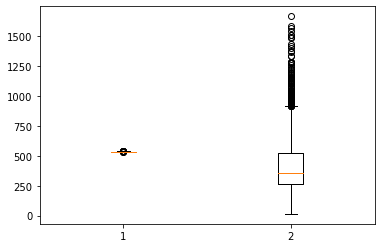

In [34]:
data = [dist_rand, dist_cross]
plt.boxplot(data)

In [16]:
# display(feature_df)
# for c in feature_df:
#     print(c)

# for k in range(0,1):
#     print(k)

In [17]:
# test feature binarizer
# from pyexplainer.features import *
# fb = FeatureBinarizer(negations=True)
# fb.fit(x_train)
# display(fb.transform(feature_df))

In [18]:
# search_function='randompertubation'
# i = 3

# X_explain = feature_df.iloc[[i]]
# y_explain = test_label.iloc[[i]]

# row_index = str(X_explain.index[0])

# start = time.time()

# pyExp_obj = pyExp.explain(X_explain,
#                            y_explain,
#                            search_function = search_function, 
#                            top_k = 1000,
#                            max_rules=2000, 
#                            max_iter =None, 
#                            cv=5,
#                            explainer='rulefit',
#                            debug = False)

In [19]:
print(pyExp_obj.keys())

dict_keys(['synthetic_data', 'synthetic_predictions', 'X_explain', 'y_explain', 'indep', 'dep', 'local_model', 'top_k_positive_rules', 'top_k_negative_rules'])


In [24]:
# display(pyExp_obj['synthetic_data_fb'])

In [23]:
# local_model = pyExp_obj['local_model']
# print(local_model.predict(X_explain.values))
# print('------------------Explanation from local model-------------------------')
# print(local_model.explain())

[False]


In [11]:
# display(pyExp_obj['X_explain'])

In [12]:
# print(local_model.predict(pyExp_obj['X_explain_fb']))

### sample code for RQ1

In [26]:
# synthetic_instances = pyExp_obj['synthetic_data']
# sample_instance = pyExp_obj['X_explain']

In [23]:
# def agg_list(val):
#     return np.mean(val), np.median(val), np.max(val)

# cos_sim = cosine_similarity(sample_instance.values.reshape(1,-1), synthetic_instances.values)[0]
# euclid_dist = euclidean_distances(sample_instance.values.reshape(1,-1), synthetic_instances.values)[0]

### sample code for RQ2

In [35]:
# '''get prediction from global model then compare with result obtained from model (but how to compare??)'''

# local_model = pyExp_obj['local_model']
# '''In case pyExp uses logistic rule regression'''
# fb_sample_instance = pyExp.feature_binarizer.transform(sample_instance)
# # print(pyExp.feature_binarizer.transform(sample_instance))
# local_pred = local_model.predict(fb_sample_instance)
# local_pred_prob = local_model.predict_proba(fb_sample_instance)

# '''In case pyExp uses RuleFit'''
# # local_pred = local_model.predict(sample_instance)
# # local_pred_prob = local_model.predict_proba(sample_instance)

# print(local_pred, local_pred_prob)

[False] [0.06562197]


In [13]:
# test rulefit
search_function='randompertubation'
print('------------------Prediction from local model-------------------------')
for i in [3,5,7,20,50,100,83,25,163,127]:
    X_explain = feature_df.iloc[[i]]
    y_explain = test_label.iloc[[i]]

    row_index = str(X_explain.index[0])

    start = time.time()

    try:
        pyExp_obj = pyExp.explain(X_explain,
                                   y_explain,
                                   search_function = search_function, 
                                   top_k = 1000,
                                   max_rules=2000, 
                                   max_iter =None, 
                                   cv=5,
                                   explainer='LRR',
                                   debug = False)
        end = time.time()
#         print('time spent to train LRR:',str(end-start),'secs')
        
        local_model = pyExp_obj['local_model']
        print(local_model.explain())
        
#         print(global_model.predict_proba(X_explain)[:,1], local_model.predict_proba(pyExp.scaler.transform(X_explain.values))[:,1])
#         print(local_model.explain())
        print('-'*100)
    except:
        print('-'*100)
        print('there is only 1 class in the generated instances')
        print('-'*100)


------------------Prediction from local model-------------------------


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


           rule coefficient
0   (intercept)    0.926494
1  nrev <= 1.00  -11.265911
2    nd <= 1.00   -3.340535
----------------------------------------------------------------------------------------------------


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


            rule coefficient
0    (intercept)   -4.822969
1   nrev <= 1.00  -21.790036
2    ent <= 0.90    11.04842
3  asawr <= 0.16    2.480303
4    nuc <= 3.00    2.480303
----------------------------------------------------------------------------------------------------


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


           rule coefficient
0   (intercept)   -9.127939
1  nrev <= 2.00   12.185013
2  nrev <= 1.00   -7.495421
3   ent <= 0.63   -7.495421
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
there is only 1 class in the generated instances
----------------------------------------------------------------------------------------------------


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


            rule coefficient
0    (intercept)    0.721183
1   nrev <= 1.00   -8.482928
2  asawr <= 0.05   -7.399822
----------------------------------------------------------------------------------------------------
          rule coefficient
0  (intercept)   -3.748032
----------------------------------------------------------------------------------------------------


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


           rule coefficient
0   (intercept)   -9.149672
1  nrev <= 2.00   14.773528
2  nrev <= 1.00    -9.91744
3   ent <= 0.00   -8.247625
----------------------------------------------------------------------------------------------------


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


            rule coefficient
0    (intercept)  -10.434791
1   nrev <= 1.00  -15.862358
2  asawr <= 0.09   15.725896
----------------------------------------------------------------------------------------------------
          rule coefficient
0  (intercept)   -2.933625
----------------------------------------------------------------------------------------------------
            rule coefficient
0    (intercept)    1.111113
1     ld <= 0.00  -11.000013
2   nrev <= 1.00   -2.505401
3  asawr <= 0.00   -0.249322
4  asawr <= 0.00   -0.249322
----------------------------------------------------------------------------------------------------


/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/oathaha/.conda/envs/env_oat/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [23]:
# test rulefit
search_function='crossoverinterpolation'
print('------------------Prediction from local model-------------------------')
for i in [3,5,7,20,50,100,83,25,163,127]:
    X_explain = feature_df.iloc[[i]]
    y_explain = test_label.iloc[[i]]

    row_index = str(X_explain.index[0])

    start = time.time()

    start = time.time()
    try:
        pyExp_obj = pyExp.explain(X_explain,
                                   y_explain,
                                   search_function = search_function, 
                                   top_k = 1000,
                                   max_rules=2000, 
                                   max_iter =None, 
                                   cv=5,
                                   explainer='rulefit',
                                   debug = False)
        end = time.time()
#         print('time spent to train LRR:',str(end-start),'secs')
        
        local_model = pyExp_obj['local_model']
        
        print(global_model.predict_proba(X_explain)[:,1], local_model.predict_proba(X_explain.values)[:,1])
#         print(local_model.explain())
        print('-'*100)
    except:
        print('-'*100)
        print('there is only 1 class in the generated instances')
        print('-'*100)


------------------Prediction from local model-------------------------
[0.84] [0.96695341]
----------------------------------------------------------------------------------------------------
[0.73] [0.49372837]
----------------------------------------------------------------------------------------------------
[0.83] [0.99548978]
----------------------------------------------------------------------------------------------------
[0.67] [0.93530316]
----------------------------------------------------------------------------------------------------
[0.6] [0.94639136]
----------------------------------------------------------------------------------------------------
[0.66] [0.94685406]
----------------------------------------------------------------------------------------------------
[0.62] [0.77372941]
----------------------------------------------------------------------------------------------------
[0.75] [0.91593334]
---------------------------------------------------------------

In [14]:
import warnings
warnings.simplefilter("ignore")

In [30]:
# sample LRR when used with random perturbation

search_function='randompertubation'

for i in [3,5,7,20,50,100,83,25,163,127]:
    X_explain = feature_df.iloc[[i]]
    y_explain = test_label.iloc[[i]]

    row_index = str(X_explain.index[0])

    start = time.time()

    start = time.time()
    try:
        pyExp_obj = pyExp.explain(X_explain,
                                   y_explain,
                                   search_function = search_function, 
                                   top_k = 1000,
                                   max_rules=2000, 
                                   max_iter =None, 
                                   cv=5,
                                   explainer='LRR',
                                   debug = False)
        end = time.time()
        print('time spent to train LRR:',str(end-start),'secs')

#         local_model = pyExp_obj['local_model']
#         print('------------------Explanation from local model-------------------------')
#         print(local_model.explain())
        print('-'*100)
    except:
        print('-'*100)
        print('there is only 1 class in the generated instances')
        print('-'*100)
    

time spent to train LRR: 1.4275202751159668 secs
----------------------------------------------------------------------------------------------------
time spent to train LRR: 1.738269329071045 secs
----------------------------------------------------------------------------------------------------
time spent to train LRR: 1.0873517990112305 secs
----------------------------------------------------------------------------------------------------
time spent to train LRR: 0.9002327919006348 secs
----------------------------------------------------------------------------------------------------
time spent to train LRR: 1.3496229648590088 secs
----------------------------------------------------------------------------------------------------


IndexError: positional indexers are out-of-bounds

In [31]:
# sample LRR when used with crossover interpolation

search_function='crossoverinterpolation'

for i in [3,5,7,20,50,100,83,25,163,127]:
    X_explain = feature_df.iloc[[i]]
    y_explain = test_label.iloc[[i]]

    row_index = str(X_explain.index[0])

    start = time.time()

    start = time.time()
    pyExp_obj = pyExp.explain(X_explain,
                               y_explain,
                               search_function = search_function, 
                               top_k = 1000,
                               max_rules=2000, 
                               max_iter =None, 
                               cv=5,
                               explainer='LRR',
                               debug = False)
    end = time.time()
    print('time spent to train LRR:',str(end-start),'secs')
    
#     local_model = pyExp_obj['local_model']
#     print('------------------Explanation from local model-------------------------')
#     print(local_model.explain())
    print('-'*100)
    
    

time spent to train LRR: 28.87514853477478 secs
----------------------------------------------------------------------------------------------------
time spent to train LRR: 26.213839769363403 secs
----------------------------------------------------------------------------------------------------
time spent to train LRR: 25.021041870117188 secs
----------------------------------------------------------------------------------------------------
time spent to train LRR: 29.421844244003296 secs
----------------------------------------------------------------------------------------------------
time spent to train LRR: 26.97343945503235 secs
----------------------------------------------------------------------------------------------------


IndexError: positional indexers are out-of-bounds

In [19]:
print(pyExp_obj.keys())

dict_keys(['synthetic_data', 'synthetic_predictions', 'X_explain', 'y_explain', 'X_explain_fb', 'indep', 'dep', 'local_model'])


In [20]:
# display(pyExp_obj['synthetic_data'].columns)
# print(feature_df.index)
local_model = pyExp_obj['local_model']

In [21]:
print(local_model.explain( maxCoeffs=None))
# print(local_model.z)

          rule coefficient
0  (intercept)     1.21719
1  la <= 44.00    -2.10262
2  la <= 76.00   -0.561556


In [22]:
generated_instance = pyExp_obj['synthetic_data']
print(generated_instance.columns)
display(generated_instance)

MultiIndex([(   'la', '<=',                 1.0),
            (   'la', '<=',                 2.0),
            (   'la', '<=',                 5.0),
            (   'la', '<=',                 9.0),
            (   'la', '<=',                17.0),
            (   'la', '<=',                27.0),
            (   'la', '<=',                44.0),
            (   'la', '<=',                76.0),
            (   'la', '<=',               163.0),
            (   'ld', '<=',                 0.0),
            ...
            ('asawr', '<=',   0.433364602876798),
            ('rsawr', '<=', 0.18055330452007923),
            ('rsawr', '<=',  0.2564102564102564),
            ('rsawr', '<=',  0.3196254791765793),
            ('rsawr', '<=',  0.3754889178617992),
            ('rsawr', '<=',  0.4287529047714299),
            ('rsawr', '<=',  0.4816326530612245),
            ('rsawr', '<=',  0.5758975125536251),
            ('rsawr', '<=',  0.7078384798099763),
            ('rsawr', '<=',  0.848

feature           la                                                         \
operation         <=                                                          
value     1.000000   2.000000   5.000000   9.000000   17.000000  27.000000    
0                  0          0          0          0          0          0   
1                  0          0          0          0          0          0   
2                  0          0          0          0          0          0   
3                  0          0          0          0          0          0   
4                  0          0          0          0          0          1   
...              ...        ...        ...        ...        ...        ...   
2116               1          1          1          1          1          1   
2117               0          0          0          0          0          0   
2118               0          0          0          0          0          0   
2119               1          1          1          1          1          1   
2120               0          0          0          0          0          0   

feature                                            ld  ...      asawr  \
operation                                          <=  ...         <=   
value     44.000000  76.000000  163.000000 0.000000    ... 0.433365     
0                  0          0          0          0  ...          1   
1                  0          0          0          1  ...          1   
2                  0          0          0          0  ...          1   
3                  0          0          0          0  ...          1   
4                  1          1          1          0  ...          1   
...              ...        ...        ...        ...  ...        ...   
2116               1          1          1          0  ...          1   
2117               0          0          1          0  ...          1   
2118               1          1          1          1  ...          1   
2119               1          1          1          0  ...          1   
2120               0          0          0          0  ...          1   

feature        rsawr                                                         \
operation         <=                                                          
value     0.180553   0.256410   0.319625   0.375489   0.428753   0.481633     
0                  0          0          0          0          0          0   
1                  0          0          0          0          0          0   
2                  0          0          0          0          0          0   
3                  0          0          0          0          0          0   
4                  0          0          0          0          0          0   
...              ...        ...        ...        ...        ...        ...   
2116               0          0          0          0          0          1   
2117               1          1          1          1          1          1   
2118               0          0          0          0          0          0   
2119               0          0          0          0          0          0   
2120               1          1          1          1          1          1   

feature                                     
operation                                   
value     0.575898   0.707838   0.848712    
0                  0          1          1  
1                  0          1          1  
2                  1          1          1  
3                  0          1          1  
4                  0          1          1  
...              ...        ...        ...  
2116               1          1          1  
2117               1          1          1  
2118               0          1          1  
2119               0          0          1  
2120               1          1          1  

[2121 rows x 165 columns]

In [41]:
print(generated_instance.loc[:, (generated_instance.columns.get_level_values(0)=='la') & 
                            (generated_instance.columns.get_level_values(1)=='<=') &
                            (generated_instance.columns.get_level_values(2)==44.0)  ])

feature     la
operation   <=
value     44.0
0            0
1            0
2            0
3            0
4            1
...        ...
2116         1
2117         0
2118         1
2119         1
2120         0

[2121 rows x 1 columns]


In [23]:
# # search_function = 'crossoverinterpolation' # 'randompertubation' or 'crossoverinterpolation'
# search_functions = ['randompertubation', 'crossoverinterpolation']

# for i in range(0,len(feature_df)):
#     X_explain = feature_df.iloc[[i]]
#     y_explain = test_label.iloc[[i]]
    
#     row_index = str(X_explain.index[0])
    
#     try:
#         pyExp_obj = pyExp.explain(X_explain,
#                                    y_explain,
#                                    search_function = search_function, 
#                                    top_k = 1000, 
#                                    max_rules=2000, 
#                                    max_iter =None, 
#                                    cv=5,
#                                    debug = False)
#         pickle.dump(pyExp_obj, open(pyExp_dir+search_function+'_'+row_index+'.pkl','wb'))
        
#         synt_pred = pyExp_obj['synthetic_predictions']
#         print('{}: found {} defect from total {}'.format(row_index, str(np.sum(synt_pred)), 
#                                                          str(len(synt_pred))))
# #         print('finished', row_index)
#     except:
#         problem_index.append(row_index)
# #     print(row_index)
#     break

In [24]:
# explain_index = 13
# X_explain = feature_df.iloc[[explain_index]]
# X_explain

In [25]:
# y_explain = test_label.iloc[[explain_index]]
# y_explain

In [26]:
# search_function = 'crossoverinterpolation' # 'randompertubation' or 'crossoverinterpolation''
# start = time.time()
# create_pyExp_rule_obj = pyExp.explain(X_explain,
#                                y_explain,
#                                search_function = search_function, 
#                                top_k = 1000, 
#                                max_rules=2000, 
#                                max_iter =None, 
#                                cv=5,
#                                debug = False)

# end = time.time()

In [27]:
# print('time spent {}'.format(str(end-start)))
# pickle.dump(create_pyExp_rule_obj, open(pyExp_dir+search_function+'_'+str(explain_index)+'.pkl','wb'))

In [28]:
# display(create_pyExp_rule_obj['synthetic_data'])

In [29]:
# # print(create_pyExp_rule_obj['synthetic_predictions'])
# # print(np.sum(create_pyExp_rule_obj['synthetic_predictions']))
# display(create_pyExp_rule_obj.keys())
# print(create_pyExp_rule_obj['synthetic_predictions'])

In [5]:
pyexp_obj = pickle.load(open(pyExp_dir+'openstack_rulefit_crossoverinterpolation_2a4e50caeaa271937a23ab7c052c7e9c47c1933f.pkl','rb'))

In [7]:
print(pyexp_obj.keys())

dict_keys(['synthetic_data', 'synthetic_predictions', 'X_explain', 'y_explain', 'indep', 'dep', 'local_model', 'top_k_positive_rules', 'top_k_negative_rules', 'commit_id'])


In [14]:
local_model = pyexp_obj['local_model']
rule = local_model.get_rules()

In [15]:
# print(rule)
rule = rule[rule['type']=='rule']

In [16]:
print(rule)

                                                   rule  type      coef  \
13    rsawr > 0.22500000149011612 & ent <= 0.8650000...  rule -0.209736   
14    la > 75.92499923706055 & app <= 1.014999985694...  rule -0.219942   
15    nrev > 38.47500038146973 & nd <= 8.51000022888...  rule -0.447855   
16    app <= 1.0600000023841858 & la > 15.5700001716...  rule -0.056809   
17    la <= 112.23500061035156 & rtime <= 152.194999...  rule -0.038473   
...                                                 ...   ...       ...   
1871  rtime > 149.36000061035156 & rsawr > 0.1249999...  rule -0.315060   
1872  ns <= 1.324999988079071 & rrexp <= 2881.844970...  rule  0.299508   
1873  nrev > 0.945000022649765 & rtime <= 11.0099997...  rule  0.197306   
1874  rtime <= -39.39999961853027 & rsawr > 0.905000...  rule  0.453788   
1875                     rsawr <= -0.014999999664723873  rule  0.193728   

       support  importance  
13    0.750000    0.090818  
14    0.036667    0.041336  
15    0.0800

In [23]:
display(rule.sort_values(by='importance',ascending=False))

,rule,type,coef,support,importance
331,ndev <= 67.1349983215332 & age > 2.54999995231...,rule,-1.339971,0.380000,0.650404
347,nd > 4.265000104904175 & nrev > 15.14000034332...,rule,-1.504175,0.213333,0.616202
1114,la > 204.33499908447266 & la > 33.825000762939...,rule,-1.049840,0.263333,0.462393
588,asawr > 0.044999999925494194 & la <= 2245.4250...,rule,0.948651,0.386667,0.461980
540,rtime > 40.69499969482422 & app > 2.0299999713...,rule,0.977063,0.283333,0.440281
...,...,...,...,...,...
1833,app > 3.9850000143051147 & ent <= 0.8799999952...,rule,-0.000924,0.060000,0.000219
1568,la <= 101.9000015258789 & la <= 2277.564941406...,rule,-0.000556,0.130000,0.000187
1285,la > 1682.449951171875 & ns <= 1.3999999761581...,rule,-0.001181,0.020000,0.000165
261,la > 50.96999931335449 & app <= 0.465000003576...,rule,0.000471,0.023333,0.000071


In [24]:
display(rule.sort_values(by='coef',ascending=False))

,rule,type,coef,support,importance
540,rtime > 40.69499969482422 & app > 2.0299999713...,rule,0.977063,0.283333,0.440281
588,asawr > 0.044999999925494194 & la <= 2245.4250...,rule,0.948651,0.386667,0.461980
690,app <= 3.975000023841858 & age <= 0.8499999940...,rule,0.941952,0.006667,0.076653
882,nd > 2.3850001096725464 & rrexp <= 2276.844970...,rule,0.866176,0.700000,0.396932
527,nrev <= 15.140000343322754 & nd > 4.2650001049...,rule,0.853926,0.016667,0.109319
...,...,...,...,...,...
1054,rsawr <= 0.3050000071525574 & rtime > 7.904999...,rule,-0.889239,0.096667,0.262773
980,app <= 2.0049999952316284 & rrexp > 849.420013...,rule,-0.909646,0.110000,0.284619
1114,la > 204.33499908447266 & la > 33.825000762939...,rule,-1.049840,0.263333,0.462393
331,ndev <= 67.1349983215332 & age > 2.54999995231...,rule,-1.339971,0.380000,0.650404


In [71]:
display(rule.sort_values(by=['importance','coef'],ascending=[False,False]))
# sort by importance then get coef > 0

,rule,type,coef,support,importance
331,ndev <= 67.1349983215332 & age > 2.54999995231...,rule,-1.339971,0.380000,0.650404
347,nd > 4.265000104904175 & nrev > 15.14000034332...,rule,-1.504175,0.213333,0.616202
1114,la > 204.33499908447266 & la > 33.825000762939...,rule,-1.049840,0.263333,0.462393
588,asawr > 0.044999999925494194 & la <= 2245.4250...,rule,0.948651,0.386667,0.461980
540,rtime > 40.69499969482422 & app > 2.0299999713...,rule,0.977063,0.283333,0.440281
...,...,...,...,...,...
1833,app > 3.9850000143051147 & ent <= 0.8799999952...,rule,-0.000924,0.060000,0.000219
1568,la <= 101.9000015258789 & la <= 2277.564941406...,rule,-0.000556,0.130000,0.000187
1285,la > 1682.449951171875 & ns <= 1.3999999761581...,rule,-0.001181,0.020000,0.000165
261,la > 50.96999931335449 & app <= 0.465000003576...,rule,0.000471,0.023333,0.000071


In [70]:
display(list(rule[rule['coef']>0].sort_values(by=['coef','importance'],ascending=[False,False])['rule']))

['rtime > 40.69499969482422 & app > 2.0299999713897705 & nd <= 8.055000305175781',
 'asawr > 0.044999999925494194 & la <= 2245.425048828125 & ent <= 0.9950000047683716',
 'app <= 3.975000023841858 & age <= 0.8499999940395355 & rsawr > 0.9849999845027924',
 'nd > 2.3850001096725464 & rrexp <= 2276.844970703125 & ndev > 2.2100000381469727',
 'nrev <= 15.140000343322754 & nd > 4.265000104904175 & app > 2.9800000190734863',
 'asawr <= 0.004999999888241291 & rrexp > 1219.2150268554688',
 'rsawr > 0.23499999940395355 & ns <= 1.6200000047683716 & rrexp > 442.3300018310547',
 'rrexp > 1657.3349609375 & age <= 0.26999999582767487',
 'app <= 2.0049999952316284 & app <= 1.9599999785423279 & age > 0.7950000166893005',
 'age > 4.855000019073486 & rrexp > -45.529998779296875',
 'la <= 2245.425048828125 & la > 82.0250015258789 & nrev > 0.7299999892711639',
 'rrexp <= 849.4200134277344 & app <= 2.0049999952316284 & app <= 4.71999979019165',
 'rrexp <= 444.02000427246094 & nrev > 30.329999923706055',
 

In [65]:
list(rule[rule['coef']>0].sort_values(by=['coef', 'importance'],ascending=False))

['rule', 'type', 'coef', 'support', 'importance']